In [1]:
!pip install python-resize-image
!pip install -U scipy==1.2.0
!pip install python-archive
import numpy as np
from numpy.random import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from skimage import data, io, transform
import matplotlib.pyplot as plt
from archive import Archive
from archive import extract

tf.test.gpu_device_name()

     |████████████████████████████████| 26.6MB 127kB/s 
ERROR: tensorflow 2.2.0rc3 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.2.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Created wheel for python-archive: filename=python_archive-0.2-cp36-none-any.whl size=6473 sha256=ba2eb8322a2fe568ce6bfe542ee67966934eb9ed003839f5ca59e96bb7559a40
  Stored in directory: /root/.cache/pip/wheels/3a/3b/c2/cde06bb709d37d647cc99a812cc1a06f2704d5feb20e97fee6
Successfully built python-archive


'/device:GPU:0'

In [0]:
from PIL import Image
from resizeimage import resizeimage

In [3]:
!wget https://s3-eu-west-1.amazonaws.com/handwriting-curated-database/curated.tar.gz

--2020-05-05 09:42:40--  https://s3-eu-west-1.amazonaws.com/handwriting-curated-database/curated.tar.gz
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.53.170
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.53.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30058219 (29M) [application/x-gzip]
Saving to: ‘curated.tar.gz’

curated.tar.gz      100%[===================>]  28.67M  87.5MB/s    in 0.3s    

2020-05-05 09:42:41 (87.5 MB/s) - ‘curated.tar.gz’ saved [30058219/30058219]



In [0]:
extract('curated.tar.gz', 'curated_data')

In [0]:
from __future__ import print_function

import pandas as pd
import cv2
from scipy.misc import imresize, imrotate, imsave

# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray' 


path = 'curated_data'

In [6]:
from os import listdir
from os.path import isfile, join

character_curated = [ord(c) for c in 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz']
print([chr(i) for i in character_curated])

images = []
labels = []
for i in character_curated:
    path_img = path + '/curated/' + str(i) + '/'
    for file_name in [f for f in listdir(path_img) if isfile(join(path_img, f))]:
        img = cv2.imread(path_img + file_name, 0)
        img = cv2.resize(img,(28, 28), interpolation = cv2.INTER_AREA)
        images += [img]
        labels += [i]

images = np.array(images, dtype=np.uint8)
labels = np.array(labels, dtype=np.uint8)
print(images.shape)
print(labels.shape)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
(46102, 28, 28)
(46102,)


65


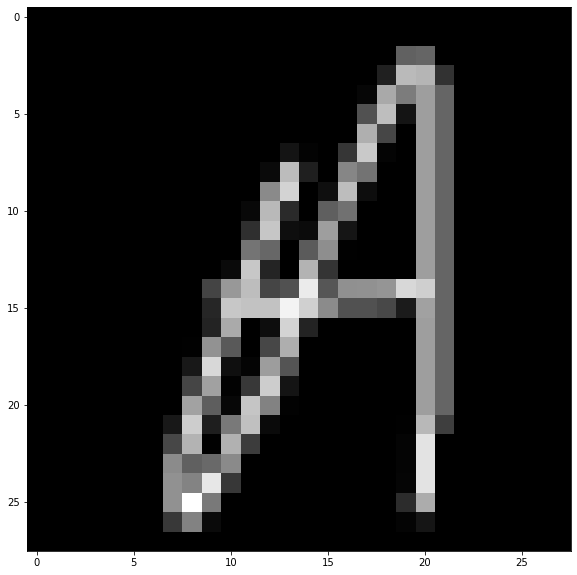

In [7]:
plt.imshow(images[0])
print(labels[0])

In [0]:
def define_discriminator(input_shape=(28, 28, 1), n_classes=93):
    # label input and embedding
    label_in = Input(shape=(1, ))
    print(label_in.shape)
    emb = Embedding(n_classes, 50)(label_in)
    print(emb.shape)
    label_h = Dense(input_shape[0] * input_shape[1])(emb)
    print(label_h.shape)
    re_label_h = Reshape((input_shape[0], input_shape[1], 1))(label_h)
    print(re_label_h.shape)
    # image input
    image_in = Input(shape=input_shape)
    # combine inputs
    merge = Concatenate()([image_in, re_label_h])
    # convnet
    h1 = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(merge)
    r1 = LeakyReLU(alpha=0.2)(h1)
    h2 = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(r1)
    r2 = LeakyReLU(alpha=0.2)(h2)
    # fully connected net
    fl = Flatten()(r2) 
    dr = Dropout(0.4)(fl)
    # output
    out = Dense(1, activation='sigmoid')(dr)
    # define and compile model
    model = Model([image_in, label_in], out)
    opt = Adam(lr=2e-4, beta_1=0.5)
    model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
    return model

In [0]:
def define_generator(latent_dim, n_classes=93):
    # label input and embedding
    label_in = Input(shape=(1, ))
    emb = Embedding(n_classes, 50)(label_in)
    label_h = Dense(7*7)(emb)
    re_label_h = Reshape((7, 7, 1))(label_h)
    # noisy image input
    noise_in = Input(shape=(latent_dim,))
    noise_h = Dense(128*7*7)(noise_in)
    noise_r = LeakyReLU(alpha=0.2)(noise_h)
    re_noise_r = Reshape((7, 7, 128))(noise_r)
    # combine inputs
    merge = Concatenate()([re_noise_r, re_label_h])
    # upsampling
    u1 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(merge)
    r1 = LeakyReLU(alpha=0.2)(u1)
    u2 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(r1)
    r2 = LeakyReLU(alpha=0.2)(u2)
    # output
    out = Conv2D(1, (7, 7), activation='tanh', padding='same')(r2)
    # define model
    model = Model([noise_in, label_in], out)
    return model

In [0]:
def define_gan(gen, dis):
    # discriminator shouldn't be trainable
    dis.trainable = False
    # get generator inputs and outputs
    gen_noise, gen_label = gen.input
    gen_output = gen.output
    print
    # feed to discriminator
    gan_output = dis([gen_output, gen_label])
    # define and compile GAN model
    model = Model([gen_noise, gen_label], gan_output)
    opt = Adam(lr=2e-4, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [0]:
def labels_updated(labels):
  for i in range(labels.shape[0]):
    if labels[i] in range(65,91):
      labels[i] -=65
    if labels[i] in range(97,123):
      labels[i]-=71
  return labels

In [0]:
def prepare_inputs(images, labels):
    if len(images.shape) > 2:
      images = np.squeeze(images)
    X = np.expand_dims(images, axis=-1)
    X = X.astype('float32')
    X = (X-127.5) / 127.5
    labels = labels_updated(labels)
    return [X, labels]
    
def generate_real_samples(images, labels, n_samples):
    rand_index = randint(0, images.shape[0], n_samples)
    X, labels = images[rand_index], labels[rand_index]
    y = np.ones((n_samples, 1)) * 0.9 # discriminator target label
    # label smoothing
    #ind = np.random.choice(list(range(len(y))), size=int(len(y) * 0.01), replace=False)
    #y[ind] = 1-y[ind]
    return [X, labels], y

def generate_latent_noise(latent_dim, n_samples, n_classes=93):
    xin = randn(latent_dim * n_samples)
    xin = xin.reshape(n_samples, latent_dim)
    labels = randint(0, n_classes, n_samples)  #  generator class label
    return xin, labels

def generate_fake_samples(gen, latent_dim, n_samples):
    zin, lin = generate_latent_noise(latent_dim, n_samples)
    images = gen.predict([zin, lin])
    y = np.zeros((n_samples, 1))  # discriminator target label
    # label smoothing
    #ind = np.random.choice(list(range(len(y))), size=int(len(y) * 0.01), replace=False)
    #y[ind] = 1-y[ind]
    return [images, lin], y

In [0]:
def train_gan(gen, dis, gan_model, images, labels, latent_dim, n_epochs=100, batch_size=128):
    batch_per_epoch = int(images.shape[0] / batch_size)
    half_batch = int(batch_size / 2)
    # enumerate epochs
    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            # train discriminator on real images
            [X_real, labels_real], y_real = generate_real_samples(images, labels, half_batch)
            d_loss1, _ = dis.train_on_batch([X_real, labels_real], y_real)
            # train discriminator on generated images
            [X_fake, labels_fake], y_fake = generate_fake_samples(gen, latent_dim, half_batch)
            #d_loss2 = dis.evaluate([X_fake, labels_fake], y_fake)[0]
            #if d_loss2 > 0.5:
            d_loss2, _ = dis.train_on_batch([X_fake, labels_fake], y_fake)
            # prepare generator input
            [zin, label_in] = generate_latent_noise(latent_dim, batch_size)
            # invert labels for fake samples (prevent vanishing gradients)
            y_gan = np.ones((batch_size, 1))
            # label smoothing
            #ind = np.random.choice(list(range(len(y_gan))), size=int(len(y_gan) * 0.01), replace=False)
            #y_gan[ind] = 1-y_gan[ind]
            # update generator loss
            g_loss = gan_model.train_on_batch([zin, label_in], y_gan)
            # output losses
            if j % 50 == 0:
              print('Epoch {}, batch {}/{}:\tDiscriminator: real loss {}, fake loss {}\tGenerator: loss {}'
                  .format(i+1, j+1, batch_per_epoch, d_loss1, d_loss2, g_loss))
    # save the models
    gen.save('generator.h5')
    dis.save('discriminator.h5')
    gan_model.save('gan.h5')    

In [0]:
#def labels_mapping():
#  labels_map = {i-65 :i for i in range(65, 91)}
#  labels_map.update({i-71 : i for i in range(97,123)})
#  return labels_map

In [15]:
latent_dim = 100
images, labels = prepare_inputs(images, labels)
print(images.shape, labels.shape)
#labels_map = labels_mapping()
dis = define_discriminator()
gen = define_generator(latent_dim)
gan_model = define_gan(gen, dis)
print("\nDiscriminator\n")
dis.summary()
print("\nGenerator\n")
gen.summary()
print("\nGAN\n")
gan_model.summary()

(46102, 28, 28, 1) (46102,)
(None, 1)
(None, 1, 50)
(None, 1, 784)
(None, 28, 28, 1)

Discriminator

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        4650        input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 1, 784)       39984       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                      

In [16]:
train_gan(gen, dis, gan_model, images, labels, latent_dim, n_epochs=50, batch_size=128)

Epoch 1, batch 1/360:	Discriminator: real loss 0.12671582400798798, fake loss 0.25106361508369446	Generator: loss 0.6917116641998291
Epoch 1, batch 51/360:	Discriminator: real loss 0.14379869401454926, fake loss 0.1288508176803589	Generator: loss 1.0829033851623535
Epoch 1, batch 101/360:	Discriminator: real loss 0.04834098368883133, fake loss 0.03825363889336586	Generator: loss 1.7101373672485352
Epoch 1, batch 151/360:	Discriminator: real loss 0.011477377265691757, fake loss 0.014165375381708145	Generator: loss 2.4679689407348633
Epoch 1, batch 201/360:	Discriminator: real loss 0.01752643845975399, fake loss 0.007035626098513603	Generator: loss 2.7751612663269043
Epoch 1, batch 251/360:	Discriminator: real loss 0.011801403015851974, fake loss 0.0037334905937314034	Generator: loss 2.941854238510132
Epoch 1, batch 301/360:	Discriminator: real loss 0.009356465190649033, fake loss 0.005079336930066347	Generator: loss 3.331509828567505
Epoch 1, batch 351/360:	Discriminator: real loss 0.00

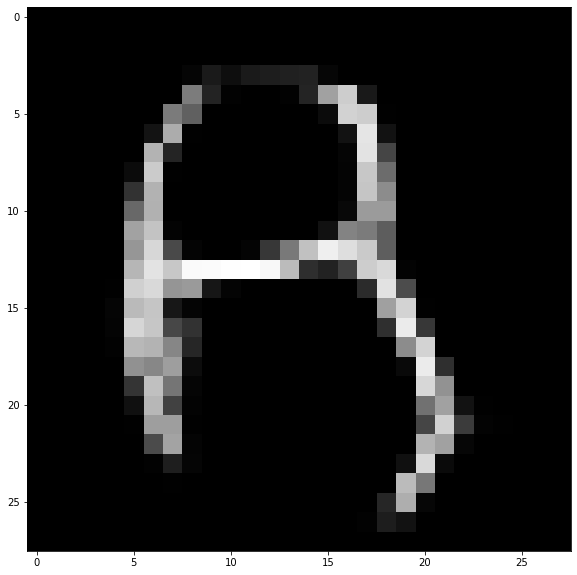

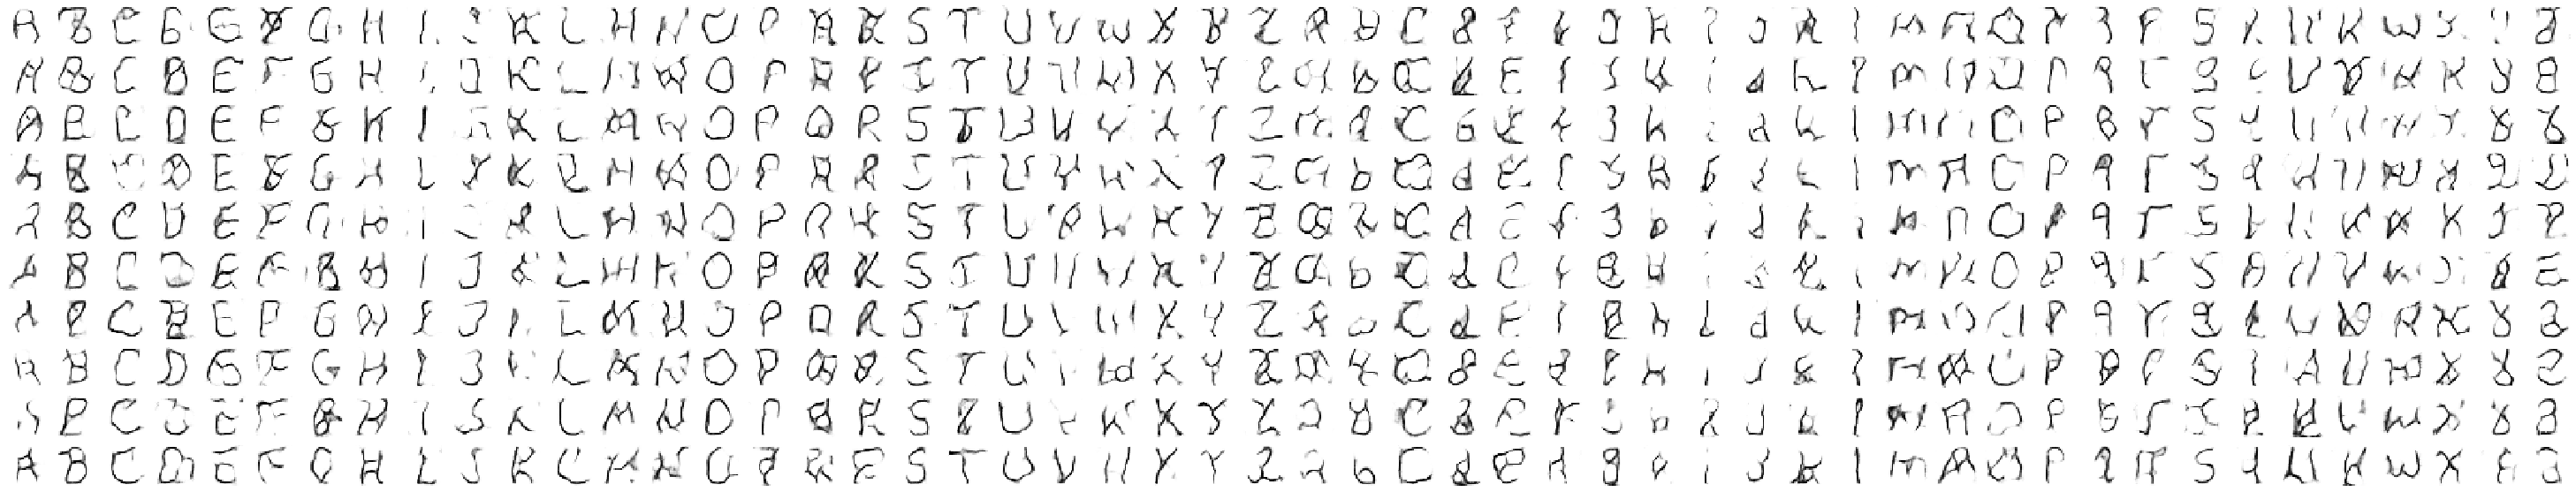

In [19]:
def show_generated(examples, n, c):
  fig = plt.figure(figsize=(c, n))
  for i in range(n*c):
    img = fig.add_subplot(n, c, i+1)
    plt.axis('off')
    plt.imshow(examples[i,:,:,0], cmap='gray_r')
  plt.show()

n = 10
c = 52

model = load_model('generator.h5')
noise, _ = generate_latent_noise(latent_dim, n*c)
labs = np.asarray([x for _ in range(n) for x in range(c)])

X = model.predict([noise, labs])
# scale from [-1, 1] to [0, 1]
X = (X + 1) / 2.0
x = np.squeeze(X[0])
plt.imshow(x)

show_generated(X, n, c)